<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/transformer_for_proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

Using TensorFlow backend.


## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, tf.keras.utils.to_categorical(msa_ori,states)

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/1BXYA.fas

In [0]:
names,seqs = parse_fasta("1BXYA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(2025, 60)
(2025, 60, 21)


In [0]:
len("ARNDCQEGHILKMFPSTWYV-")

21

# Transformer model

Based on:
https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/r2/tutorials/text/transformer.ipynb


# Attention layer

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model): #position = length of seq
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
def scaled_dot_product_attention(q, k, v, mask=None):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, attention_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2, attention_weights

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    #x = tf.one_hot(x, depth=self.d_model, axis=-1)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x, attn_weights = self.enc_layers[i](x, training, mask)
      
    
    return x, attn_weights # (batch_size, input_seq_len, d_model)

In [0]:
import os

In [0]:
tf.reset_default_graph()

nrow = msa.shape[0] # number of sequences
ncol = msa.shape[1] # length of sequence
states = msa.shape[2]+1 # number of states (or categories)


MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="MSA")
MASK = tf.placeholder(tf.float32,shape=(None,ncol),name="MASK")
MSA_MASKED = tf.placeholder(tf.int32,shape=(None,ncol),name="MSA_MASKED")
is_train = tf.placeholder(tf.bool, name="is_train");

sample_encoder = Encoder(4, 40, 10, 40*4, 60)
Z, attn_weights= sample_encoder(MSA_MASKED, is_train, None)

fO = tf.keras.layers.Dense(states, name='fO')
O = fO(Z)

weights = fO.weights

H = tf.nn.softmax_cross_entropy_with_logits_v2(labels = MSA, logits=O)
ECE = tf.reduce_mean(tf.exp(H))
l1 = H*(1-MASK)
loss = tf.reduce_sum(l1)

correct = tf.equal(tf.argmax(tf.nn.softmax(O, axis=-1), -1), tf.argmax(MSA, -1))
correct = tf.cast(correct, tf.float32)
accuracy = tf.reduce_mean(correct)



optimizer = tf.train.AdamOptimizer(0.0005)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss)
    

W0905 23:57:55.185020 139702054786944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 23:57:55.195506 139702054786944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
weights

[<tf.Variable 'fO/kernel:0' shape=(40, 22) dtype=float32>,
 <tf.Variable 'fO/bias:0' shape=(22,) dtype=float32>]

In [0]:
def new_mask(msa_ori, p=0.95):
  mask_inpt = np.random.binomial(1, p, size=msa_ori.shape)
  indx = np.argwhere(mask_inpt == 0)
  rand_indx = indx[np.random.choice(indx.shape[0], indx.shape[0], replace=False),:]
  masked_msa_inpt = np.copy(msa_ori)
  for i in range(indx.shape[0]):
    if i < np.int(indx.shape[0]*0.8):
      i1, i2 = rand_indx[i,:]
      masked_msa_inpt[i1, i2] = 21
    elif np.int(indx.shape[0]*0.8) <= i < np.int(indx.shape[0]*0.9):
      i1, i2 = rand_indx[i,:]
      masked_msa_inpt[i1, i2] = np.random.randint(21)
      
  return masked_msa_inpt, mask_inpt[:,:], indx.shape[0]

#Helper function
def batch_generator(x, y, z, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(x.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, x.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, x.shape[0])
    part = idx[start_idx:end_idx]
    yield x[part,...], y[part,...], z[part, ...]

In [0]:
n_epochs = 50000
batch_size = 32
p=0.85
msa_gt = tf.keras.utils.to_categorical(msa_ori, 22)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    masked_msa_inpt, mask_inpt, number0 = new_mask(msa_ori, p)
    gen = batch_generator(msa_gt, masked_msa_inpt, mask_inpt,  batch_size) #create batch generator
    total_loss = 0
    for j in range(np.int(msa_ori.shape[0]/batch_size)):
      msa_g, msa_i, mask_i = gen.__next__()
      _, batch_loss= sess.run([train_op, loss], feed_dict={MSA: msa_g, MSA_MASKED: msa_i, MASK:mask_i, is_train:True})
      total_loss += batch_loss
    if i % 10 == 0:
      Z_, O_, weights_, attn_weights_, accuracy_, ECE_ = sess.run([Z, O, weights, attn_weights, accuracy, ECE], feed_dict={MSA: msa_gt, MSA_MASKED: msa_ori, is_train:False})
      print('epoch: {0}, total: {1:.3f}, acc: {2:.3f}, ECE: {3:.3f}'.format((i+1), total_loss/(msa_ori.shape[0]/batch_size), accuracy_, ECE_))

epoch: 1, total: 810.579, acc: 0.371, ECE: 15.526
epoch: 11, total: 428.199, acc: 0.861, ECE: 7.294
epoch: 21, total: 397.335, acc: 0.891, ECE: 6.347
epoch: 31, total: 375.340, acc: 0.897, ECE: 6.469
epoch: 41, total: 353.639, acc: 0.911, ECE: 5.721
epoch: 51, total: 341.554, acc: 0.902, ECE: 5.913
epoch: 61, total: 334.130, acc: 0.909, ECE: 6.454
epoch: 71, total: 331.322, acc: 0.905, ECE: 6.045
epoch: 81, total: 322.362, acc: 0.907, ECE: 5.881
epoch: 91, total: 319.287, acc: 0.910, ECE: 5.558
epoch: 101, total: 315.447, acc: 0.909, ECE: 5.590
epoch: 111, total: 315.004, acc: 0.914, ECE: 5.738
epoch: 121, total: 303.832, acc: 0.912, ECE: 6.595
epoch: 131, total: 299.750, acc: 0.910, ECE: 6.033
epoch: 141, total: 300.426, acc: 0.913, ECE: 6.636
epoch: 151, total: 293.487, acc: 0.916, ECE: 5.897
epoch: 161, total: 290.503, acc: 0.918, ECE: 5.777
epoch: 171, total: 293.346, acc: 0.919, ECE: 6.069
epoch: 181, total: 293.948, acc: 0.918, ECE: 5.748
epoch: 191, total: 285.095, acc: 0.918, E

KeyboardInterrupt: ignored

In [0]:
W = weights_[0]

In [0]:
from sklearn.manifold import TSNE
W_embedded = TSNE(n_components=2, perplexity=3).fit_transform(W.T)
W_embedded.shape

(22, 2)

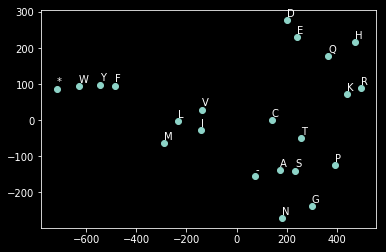

In [0]:
fig, ax = plt.subplots()
ax.scatter(W_embedded[:,0], W_embedded[:,1])

k=0
for i in "ARNDCQEGHILKMFPSTWYV-*":
  ax.annotate(i, (W_embedded[k,0], W_embedded[k,1]+10.0))
  k += 1

In [0]:
import umap

In [0]:
W_embedded = umap.UMAP(
    n_neighbors=4,
    min_dist=0.0,
    n_components=2,
    random_state=0,
).fit_transform(W.T)

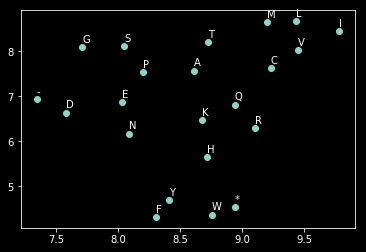

In [0]:
fig, ax = plt.subplots()
ax.scatter(W_embedded[:,0], W_embedded[:,1])

k=0
for i in "ARNDCQEGHILKMFPSTWYV-*":
  ax.annotate(i, (W_embedded[k,0], W_embedded[k,1]+0.1))
  k += 1

In [0]:
O_.shape

(2025, 60, 22)

In [0]:
attn_weights_.shape

(2025, 10, 60, 60)

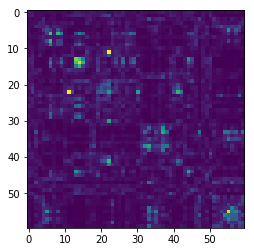

In [0]:
plt.imshow(attn_weights_[0,8,:,:]+attn_weights_[0,8,:,:].T)

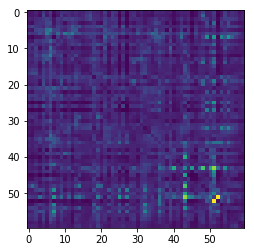

In [0]:
plt.imshow(np.mean(attn_weights_, axis=(0,1))[:,:]+np.mean(attn_weights_, axis=(0,1))[:,:].T)

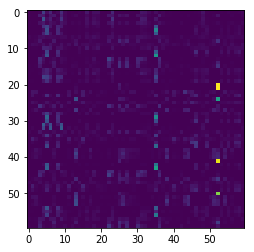

In [0]:
plt.imshow(attn_weights_[0,1,:,:])

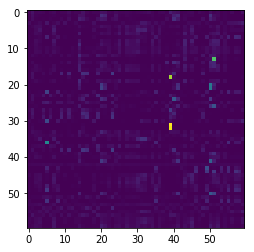

In [0]:
plt.imshow(attn_weights_[0,2,:,:])

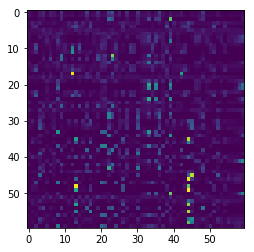

In [0]:
plt.imshow(attn_weights_[0,3,:,:])

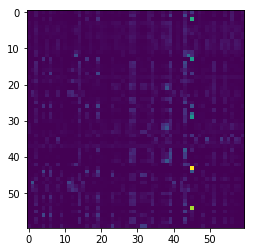

In [0]:
plt.imshow(attn_weights_[0,4,:,:])

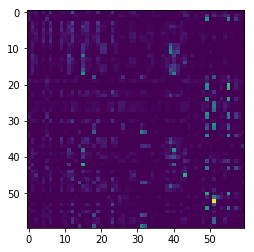

In [0]:
plt.imshow(attn_weights_[0,5,:,:])

In [0]:
Embd = np.exp(O_)/np.sum(np.exp(O_), axis=-1)[...,np.newaxis]

In [0]:
Embd.shape

(2025, 60, 22)

In [0]:
entropy = -np.sum(Embd * np.log(Embd), axis=-1)

In [0]:
entropy.shape

(2025, 60)

In [0]:
np.max(entropy)

2.618532

In [0]:
Embd.shape

(2025, 60, 22)

In [0]:
Embd1 = np.reshape(Embd, newshape=(2025,-1))

In [0]:
C = np.cov(Embd1.T)

In [0]:
C.shape

(1320, 1320)

In [0]:
C_inv = np.linalg.pinv(C)

In [0]:
C_inv.shape

(1320, 1320)

In [0]:
WC = np.reshape(C_inv, newshape=(1320, 60, 22))

In [0]:
WC = np.reshape(WC, newshape=(60,22, 60, 22))

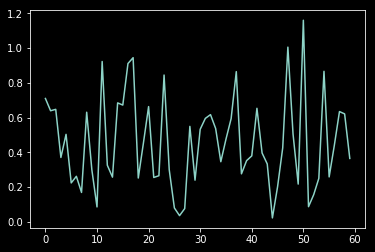

In [0]:
plt.plot(np.mean(entropy, axis=0))

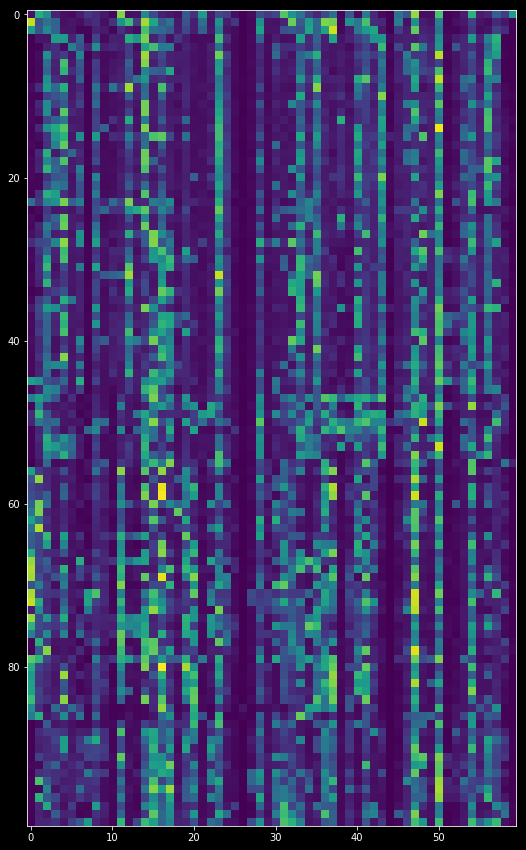

In [0]:
plt.figure(figsize=(10,15))
plt.imshow(entropy[0:100, :])

# GREMLIN

In [0]:
def GREMLIN_simple(msa_ori, embd, opt_iter=200):
  
  # collecting some information about input msa
  nrow = msa_ori.shape[0] # number of sequences
  ncol = msa_ori.shape[1] # length of sequence
  states = 22 # number of states (or categories)

  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  b = tf.get_variable("b", [ncol,states])
  w = tf.get_variable("w", [ncol,states,ncol,states], 
                      initializer=tf.initializers.zeros)

  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  MSA_out = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa_out")
  MSA_inpt = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa_in")
  
  # dense layer + softmax activation
  MSA_pred = tf.nn.softmax(tf.tensordot(MSA_inpt,w,2)+b,-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA_out,MSA_pred))

  # add L2 regularization
  reg_b = 0.01 * tf.reduce_sum(tf.square(b))
  reg_w = 0.01 * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * (states-1)
  loss = loss + reg_b + reg_w

  # setup optimizer
  learning_rate = 0.1 * np.log(nrow)/ncol
  opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  
  
  msa = tf.keras.utils.to_categorical(msa_ori, states)
  # optimize!
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # initialize bias
    pc = 0.01 * np.log(nrow)
    b_ini = np.log(np.sum(msa,0) + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    sess.run(b.assign(b_ini))
    
    print("starting",sess.run(loss,{MSA_inpt:msa, MSA_out:embd}))

    for i in range(opt_iter):
      sess.run(opt,{MSA_inpt:msa, MSA_out:embd})
      if (i+1) % 10 == 0:
        print((i+1),sess.run(loss,{MSA_inpt:msa, MSA_out:embd}))

    # save the weights (aka V and W parameters of the MRF)
    V = sess.run(b)
    W = sess.run(w)
  return(V,W) 

In [0]:
%%time
V,W = GREMLIN_simple(msa_ori, Embd)

starting 149824.12
10 96001.19
20 89570.93
30 87160.445
40 86263.32
50 85851.92
60 85641.76
70 85524.91
80 85451.99
90 85401.02
100 85362.09
110 85330.82
120 85304.86
130 85282.734
140 85263.56
150 85246.734
160 85231.85
170 85225.93
180 85210.02
190 85197.39
200 85186.84
CPU times: user 3.07 s, sys: 918 ms, total: 3.99 s
Wall time: 3.76 s


## get contacts

In [0]:
W_Embd = np.einsum('ijk, irs -> jkrs', Embd, Embd)

In [0]:
W_Embd.shape

(60, 22, 60, 22)

In [0]:
W.shape

(60, 22, 60, 22)

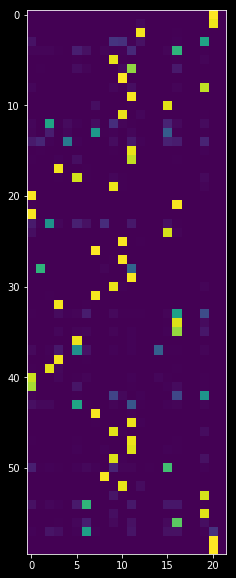

In [0]:
plt.figure(figsize=(5,10))
plt.imshow(Embd[3,:,:])

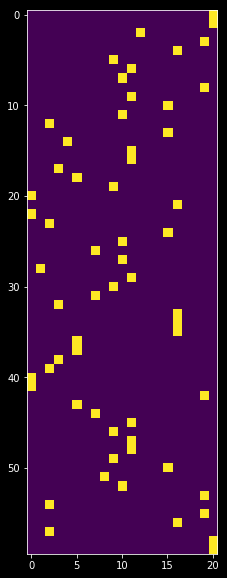

In [0]:
plt.figure(figsize=(5,10))
plt.imshow(msa[3,:,:])

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-2,:,:-2]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

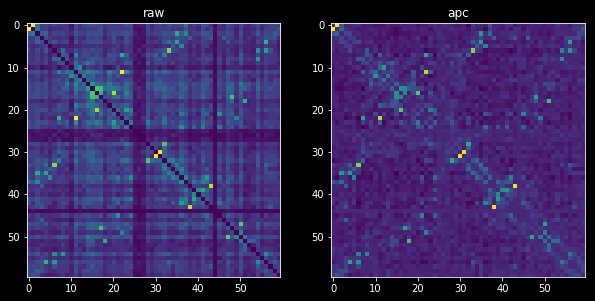

In [0]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

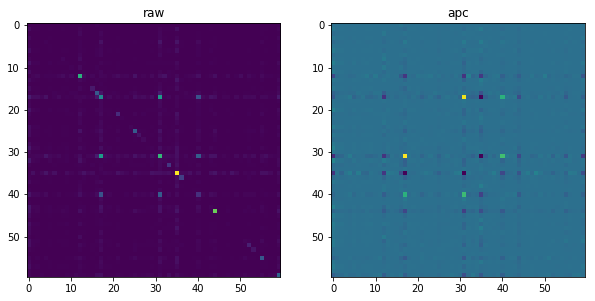

In [0]:
raw, apc = get_mtx(WC)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

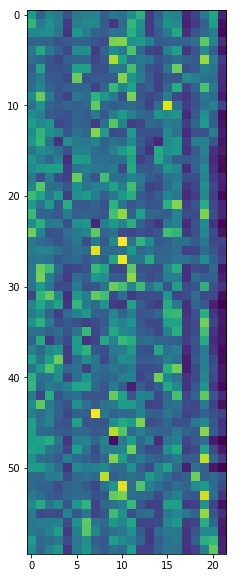

In [0]:
plt.figure(figsize=(5,10))
plt.imshow(V)